本指南使用机器学习按品种对鸢尾花进行分类。它利用TensorFlow的Eager Execution来执行以下操作：1。构建模型，2。使用样本数据训练该模型，以及3.利用该模型对未知数据进行预测。

#### TensorFlow编程
本指南采用了以下高级TensorFlow概念：

- 启用Eager Execution开发环境，
- 使用数据集API导入数据，
- 使用TensorFlow的Keras API构建模型和层。

本教程采用了与许多TensorFlow程序相似的结构：

1. 导入和解析数据集。
2. 选择模型类型。
3. 训练模型。
4. 评估模型的效果。
5. 使用经过训练的模型进行预测。

#### 设置程序

 配置导入和Eager Execution
 
导入所需的Python模块（包括TensorFlow），然后针对此程序启用Eager Execution。借助Eager Execution，TensorFlow会立即评估各项操作，并返回具体的值，而不是创建稍后执行的计算图。如果您习惯使用REPL或python交互控制台，对于Eager Execution您会用起来得心应手.TensorFlow 1.8及以上版本中提供了Eager Execution。

Eager Execution一旦启用，便无法在同一程序中停用。如需了解详情，请参阅Eager Execution指南。

In [1]:
from __future__ import absolute_import,division,print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version :{}".format(tf.VERSION))
print("Eager execution:{}".format(tf.executing_eagerly()))

TensorFlow version :1.13.1
Eager execution:True


#### 鸢尾花分类问题
想象一下，您是一名植物学家，正在寻找一种能够对所发现的每株鸢尾花进行自动归类的方法。机器学习可提供多种从统计学上分类花卉的算法。例如，一个复杂的机器学习程序可以根据照片对花卉进行分类。我们的要求并不高 - 我们将根据鸢尾花花萼和花瓣的长度和宽度对其进行分类。

鸢尾属约有300个品种，但我们的程序将仅对下列三个品种进行分类：

- 山鸢尾
- 维吉尼亚鸢尾
- 变色鸢尾
***
![山鸢尾](https://tensorflow.google.cn/images/iris_three_species.jpg)
![维吉尼亚鸢尾](https://tensorflow.google.cn/images/iris_three_species.jpg)
![变色鸢尾](https://tensorflow.google.cn/images/iris_three_species.jpg)
***
三个鸢尾花品种的花瓣几何对比：山鸢尾，维吉尼亚鸢尾和变色鸢尾
***
 
幸运的是，有人已经创建了一个包含120株鸢尾花的数据集（其中有花萼和花瓣的测量值）。这是一个在入门级机器学习分类问题中经常使用的经典数据集。

#### 导入和解析训练数据集
下载数据集文件并将其转换为可供此Python程序使用的结构。

#### 下载数据集
使用tf.keras.utils.get_file函数下载训练数据集文件。该函数会返回下载文件的文件路径。

In [3]:
 train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"
# train_dataset_url = "./data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                          origin=train_dataset_url)

print("Local copy of the dataset file:{}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file:C:\Users\fangmw\.keras\datasets\iris_training.csv


In [4]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features:{}".format(feature_names))
print("Label:{}".format(label_name))

Features:['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label:species


In [5]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

#### 创建一个 tf.data.Dataset
TensorFlow的数据集API可处理在向模型加载数据时遇到的许多常见情况。这是一种高阶API，用于读取数据并将其转换为可供训练使用的格式。如需了解详情，请参阅数据集快速入门指南。

由于数据集是CSV格式的文本文件，请使用make_csv_dataset函数将数据解析为合适的格式。由于此函数为训练模型生成数据，默认行为是对数据进行随机处理（`shuffle=True, shuffle_buffer_size=10000`），并且无限期重复数据集（`num_epochs=None`） 。我们还设置了的`batch_size`参数。

In [6]:
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1
)

Instructions for updating:
Use `tf.data.experimental.make_csv_dataset(...)`.


`make_csv_dataset`报道查看函数`(features, label)`对的`tf.data.Dataset`，其中`features`的英文一个字典搜索：`{'feature_name': value}`

启用Eager Execution后，这些`Dataset`对象便可迭代。我们来看看一批特征：

In [7]:
features,labels = next(iter(train_dataset))
features

Instructions for updating:
Colocations handled automatically by placer.


OrderedDict([('sepal_length',
              <tf.Tensor: id=58, shape=(32,), dtype=float32, numpy=
              array([6.3, 6. , 6.4, 4.7, 6.3, 4.4, 6.3, 6.7, 5.8, 7.4, 6.5, 6.4, 4.9,
                     5. , 7.7, 6.4, 6.5, 6.7, 5.5, 5.7, 7. , 6.5, 5.4, 6.9, 6.3, 6.9,
                     5. , 5.1, 4.6, 6.7, 5.2, 4.5], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=59, shape=(32,), dtype=float32, numpy=
              array([2.7, 3. , 2.8, 3.2, 2.5, 3. , 3.4, 3.1, 2.6, 2.8, 3. , 3.1, 3. ,
                     3.3, 3.8, 3.2, 2.8, 3.1, 3.5, 2.8, 3.2, 3.2, 3.4, 3.1, 3.3, 3.2,
                     3.6, 2.5, 3.1, 3. , 3.4, 2.3], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=56, shape=(32,), dtype=float32, numpy=
              array([4.9, 4.8, 5.6, 1.6, 5. , 1.3, 5.6, 4.4, 4. , 6.1, 5.8, 5.5, 1.4,
                     1.4, 6.7, 5.3, 4.6, 5.6, 1.3, 4.1, 4.7, 5.1, 1.5, 4.9, 6. , 5.7,
                     1.4, 3. , 1.5, 5.2, 1.4, 1.3],

请注意，类似特征会归为一组，即分为一批。每个样本行的字段都会附加到相应的特征数组中。更改batch_size柯林斯设置存储在这些特征数组中的样本数。

绘制该批次中的几个特征后，就会开始看到一些集群现象：

Text(0, 0.5, 'Sepal length')

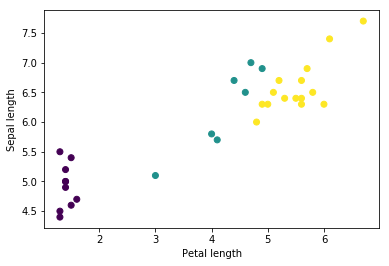

In [10]:
plt.scatter(features['petal_length'],
           features['sepal_length'],
           c=labels,
           cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")

要简化模型构建步骤，请一个创建³³以函数将特征字典搜索重新打包为形状为`(batch_size, num_features)`的单个数组。

此函数使用tf.stack方法，该方法从张量列表中获取值，并创建指定维度的组合张量。

In [11]:
def pack_features_vector(features,labels):
    features = tf.stack(list(features.values()),axis=1)
    return features,labels

使用然后tf.data.Dataset.map方法将每个(features,label)对的features打包到训练数据集中：

In [12]:
train_dataset = train_dataset.map(pack_features_vector)

Dataset的特点元素现在是形状为`(batch_size, num_features)`的数组。我们来看看前几个样本：

In [13]:
features,labels = next(iter(train_dataset))
print(features[:5])

tf.Tensor(
[[6.3 3.3 6.  2.5]
 [4.7 3.2 1.6 0.2]
 [6.7 3.1 4.4 1.4]
 [6.  3.  4.8 1.8]
 [4.9 3.  1.4 0.2]], shape=(5, 4), dtype=float32)


In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10,activation=tf.nn.relu,input_shape=(4,)),
    tf.keras.layers.Dense(10,activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])

In [15]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=228, shape=(5, 3), dtype=float32, numpy=
array([[-0.307414  ,  0.02205812,  0.0772928 ],
       [-0.50870484, -0.7881248 , -0.26382786],
       [-0.20895942, -0.29517433, -0.16497338],
       [-0.15129359, -0.06592645, -0.06951092],
       [-0.47426808, -0.880097  , -0.23739588]], dtype=float32)>

In [16]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=234, shape=(5, 3), dtype=float32, numpy=
array([[0.25910646, 0.3602186 , 0.38067493],
       [0.32963198, 0.24927504, 0.42109305],
       [0.33756813, 0.30968404, 0.35274783],
       [0.31502643, 0.3431006 , 0.34187296],
       [0.3408661 , 0.22716142, 0.4319725 ]], dtype=float32)>

In [17]:
print("Prediction:{}".format(tf.argmax(predictions,axis=1)))
print("    Labels:{}".format(labels))

Prediction:[2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
    Labels:[2 0 1 2 0 0 0 0 1 0 2 0 0 1 1 0 1 1 2 2 2 0 2 0 0 1 0 0 0 1 1 1]


In [18]:
def loss(model,x,y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y,logits=y_)

l = loss(model,features,labels)
print("Loss test:{}".format(l))

Instructions for updating:
Use tf.cast instead.
Loss test:1.0899486541748047


In [20]:
def grad(model,inputs,targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model,inputs,targets)
    return loss_value,tape.gradient(loss_value,model.trainable_variables)

In [21]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
global_step = tf.train.get_or_create_global_step()

In [22]:
loss_value,grads = grad(model,features,labels)

print("Step:{},Initial Loss:{}".format(global_step.numpy(),
                                      loss_value.numpy()))

optimizer.apply_gradients(zip(grads,model.variables),global_step)

print("Step: {},        Loss:{}".format(global_step.numpy(),
                                       loss(model,features,labels).numpy()))

Step:0,Initial Loss:1.0899486541748047
Step: 1,        Loss:1.074742317199707


In [27]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    for x,y in train_dataset:
        loss_value,grads = grad(model,x,y)
        optimizer.apply_gradients(zip(grads,model.variables),
                                 global_step)
        
        epoch_loss_avg(loss_value)
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

        
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy:{:.3%}".format(epoch,
                                                                  epoch_loss_avg.result(),
                                                                  epoch_accuracy.result()))

Epoch 000: Loss: 1.027, Accuracy:35.000%
Epoch 050: Loss: 0.380, Accuracy:90.833%
Epoch 100: Loss: 0.240, Accuracy:97.500%
Epoch 150: Loss: 0.172, Accuracy:97.500%
Epoch 200: Loss: 0.129, Accuracy:98.333%


#### 可视化损失函数随时间推移而变化的情况
虽然输出模型的训练过程有帮助，但查看这一过程往往更有帮助。TensorBoard是与TensorFlow封装在一起的出色可视化工具，不过我们可以使用matplotlib模块创建基本图表。

解读这些图表需要一定的经验，不过您确实希望看到损失下降且准确率上升。

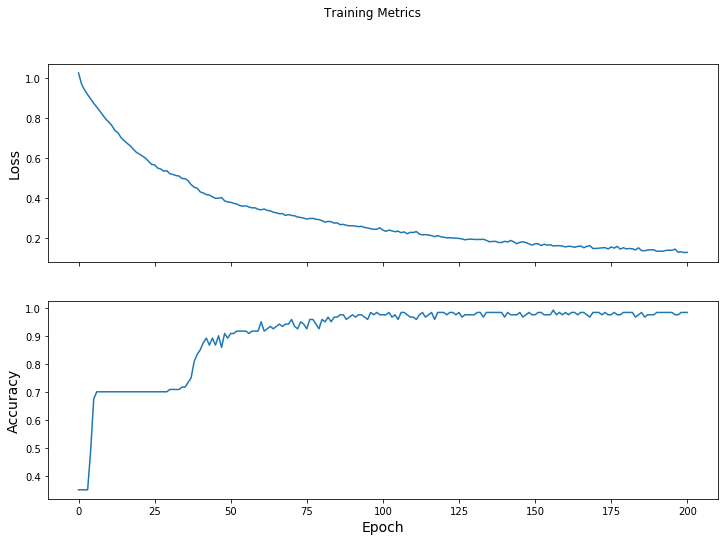

In [28]:
fig,axes = plt.subplots(2,sharex=True,figsize=(12,8))
fig.suptitle("Training Metrics")

axes[0].set_ylabel("Loss",fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(train_accuracy_results)